## eco-velo on pancreas

In this notebook we will apply our eco-velo method to the pancreas endocrinogenesis dataset. This dataset was originally published by Bastidas-Ponce and colleagues (https://doi.org/10.1242/dev.173849) and it is one of the datasets described in the original scVelo paper. 

You can use this notebook to reproduce figures 5C and S8.

In [1]:
### load libraries

# general libraries
import pandas as pd
import numpy as np

# single-cell libraries
import anndata as ad
import scanpy as sc
import scvelo as scv

# plotting libraries
import matplotlib.pyplot as plt

# dimension reduction libraries
from sklearn.decomposition import PCA #for creating PCAs
from sklearn.preprocessing import StandardScaler #for creating PCAs
import umap

# other
import sklearn as sk #used for L2 normalization
from scipy.spatial import cKDTree #used for MNN method

# import our own functions
from functions import *

In [3]:
### set scvelo settings
scv.settings.set_figure_params('scvelo', dpi_save=300, dpi=100, transparent=True)
scv.settings.verbosity = 0

### Load original dataset

Here, we load the pancreas endocrinogenesis dataset. The dataset is made accesible in the scVelo package (version 0.2.4) where you can download it using the function `scvelo.datasets.pancreas()`. 

In [4]:
### load pancreas dataset
pancreas_path = "../datasets/pancreas/pancreas.h5ad"
adata = ad.read_h5ad(pancreas_path)

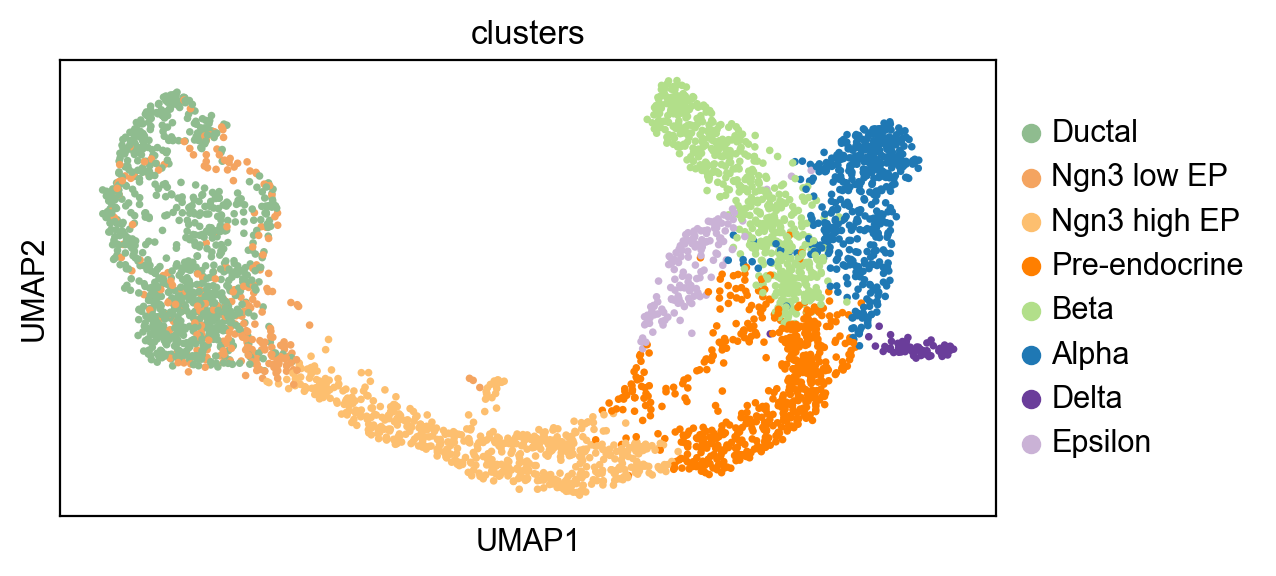

In [5]:
### plot dataset
fig, axs = plt.subplots(1, 1, figsize=(6, 3), frameon=False)
sc.pl.umap(adata, color="clusters", size=30, ax=axs)

### Processing

Here, we process the dataset. We deviate from the standard scVelo processing pipeline. If you want to know more about why certain steps of steps of processing are omitted or included, you can read all about it in our manuscript. 

First, we select 2000 HVGs on the spliced data, using analytic Pearson residuals (Lause et al., 2021 https://doi.org/10.1186/s13059-021-02451-7).

In [6]:
### select HVGs
hvgs = get_hvgs(adata, no_of_hvgs=2000, theta=100)

In [7]:
### make subset with HVGs only
adata = adata[:, hvgs]

Next, we keep only genes with sufficient unspliced and spliced counts (maximum count should be above 3).

In [8]:
### select genes that have sufficient u and s counts
minlim = 3
spliced_matrix = adata.layers['spliced'].todense()
unspliced_matrix = adata.layers['unspliced'].todense()
us_genes = (np.array(np.max(spliced_matrix, axis=0)).flatten() > minlim) & (np.array(np.max(unspliced_matrix, axis=0)).flatten() > minlim)
us_genes = adata.var_names[us_genes]
len(us_genes)

395

In [9]:
### subset for us-genes
adata = adata[:,us_genes]

Log-transform and L2 normalise the dataset. Normalisation is applied to spliced and unspliced counts seperately.

In [10]:
### log transformation of the dataset
adata.X = np.matrix(np.where(adata.X.todense() != 0, np.log(adata.X.todense()), 0))
adata.X = adata.X.todense()
adata.layers['spliced'] = np.matrix(np.where(adata.layers['spliced'].todense() != 0, np.log(adata.layers['spliced'].todense()), 0))
adata.layers['unspliced'] = np.matrix(np.where(adata.layers['unspliced'].todense() != 0, np.log(adata.layers['unspliced'].todense()), 0))

In [11]:
### L2 normalise spliced and unspliced separately
adata.X = sk.preprocessing.normalize(adata.X, norm='l2')
adata.layers['spliced'] = sk.preprocessing.normalize(adata.layers['spliced'], norm='l2')
adata.layers['unspliced'] = sk.preprocessing.normalize(adata.layers['unspliced'], norm='l2')

### Calculate new UMAP embedding

Since we removed many of the original genes from the dataset, we will recalculate the UMAP embedding. 

In [12]:
del adata.obsm['X_pca']
del adata.obsm['X_umap']

First, we run a PCA on scaled spliced data.

In [13]:
### scale data (spliced counts)
scal = StandardScaler()
spliced_scaled = scal.fit_transform(adata.layers["spliced"])

In [14]:
### run PCA
n_pcs = 10
pca = PCA(n_components=n_pcs)
pca.fit(spliced_scaled)
pca_pts = pca.transform(spliced_scaled)

In [15]:
### calculate UMAP
reducer = umap.UMAP(random_state=0, n_neighbors=30, min_dist=.8, n_components=2, metric="euclidean")
data = reducer.fit_transform(pca_pts)
adata.obsm['X_umap']=data

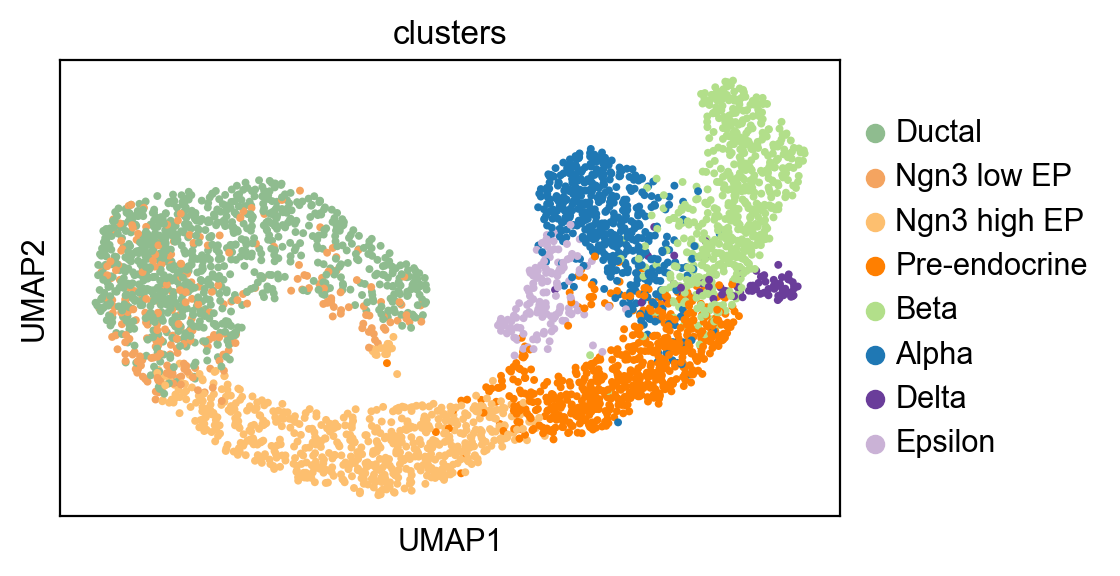

In [16]:
### plot UMAP (just spliced counts)
fig, axs = plt.subplots(1, 1, figsize=(5, 3), frameon=False)
sc.pl.umap(adata, color='clusters', ax=axs)
plt.show()

### MNN on original gene space

Last in the eco-velo workflow for each cell we will use its unspliced counts to find the mutual nearest neighbour (MNN) between all cells, defined by their spliced counts. Note: since we try to find an MNN in the first 50 neighbours, it might be that some cells are not assigned to any MNN.

In [17]:
### identify MNNs
k = 50
mnn = find_mutual_nn(adata.layers['unspliced'], adata.layers['spliced'], k = k)
print(np.sum(mnn==-1))

1943


In [18]:
### select MNNs
data = adata.obsm["X_umap"]
pos = data[mnn]
pos[np.array(mnn)==-1]=np.nan

In [19]:
### ???
NN = cKDTree(spliced_matrix).query(x=spliced_matrix, k=30, n_jobs=1)[1]
pos_mean = np.nanmean(np.array(pos)[NN], axis=1)

In [20]:
### get points for UMAP
v = np.array(pos) - data
v_mean = pos_mean - data

In [22]:
### get colors of each cluster
color_dict = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))
c=adata.obs["clusters"].map(color_dict)

In [23]:
### set arguments for visualisation
light_color = np.array([lighten_color(i, .3) for i in c])
umap_pltkwargs={"figsize":(10, 8), "frameon":False}
umap_quiver_kwargs = {"scale": 3, "angles": "xy", "scale_units": "xy", "edgecolors": "k",
                      "linewidth": 0.5, "headlength": 7, "headwidth": 5, "headaxislength": 6}
sub = np.array(mnn)>=0

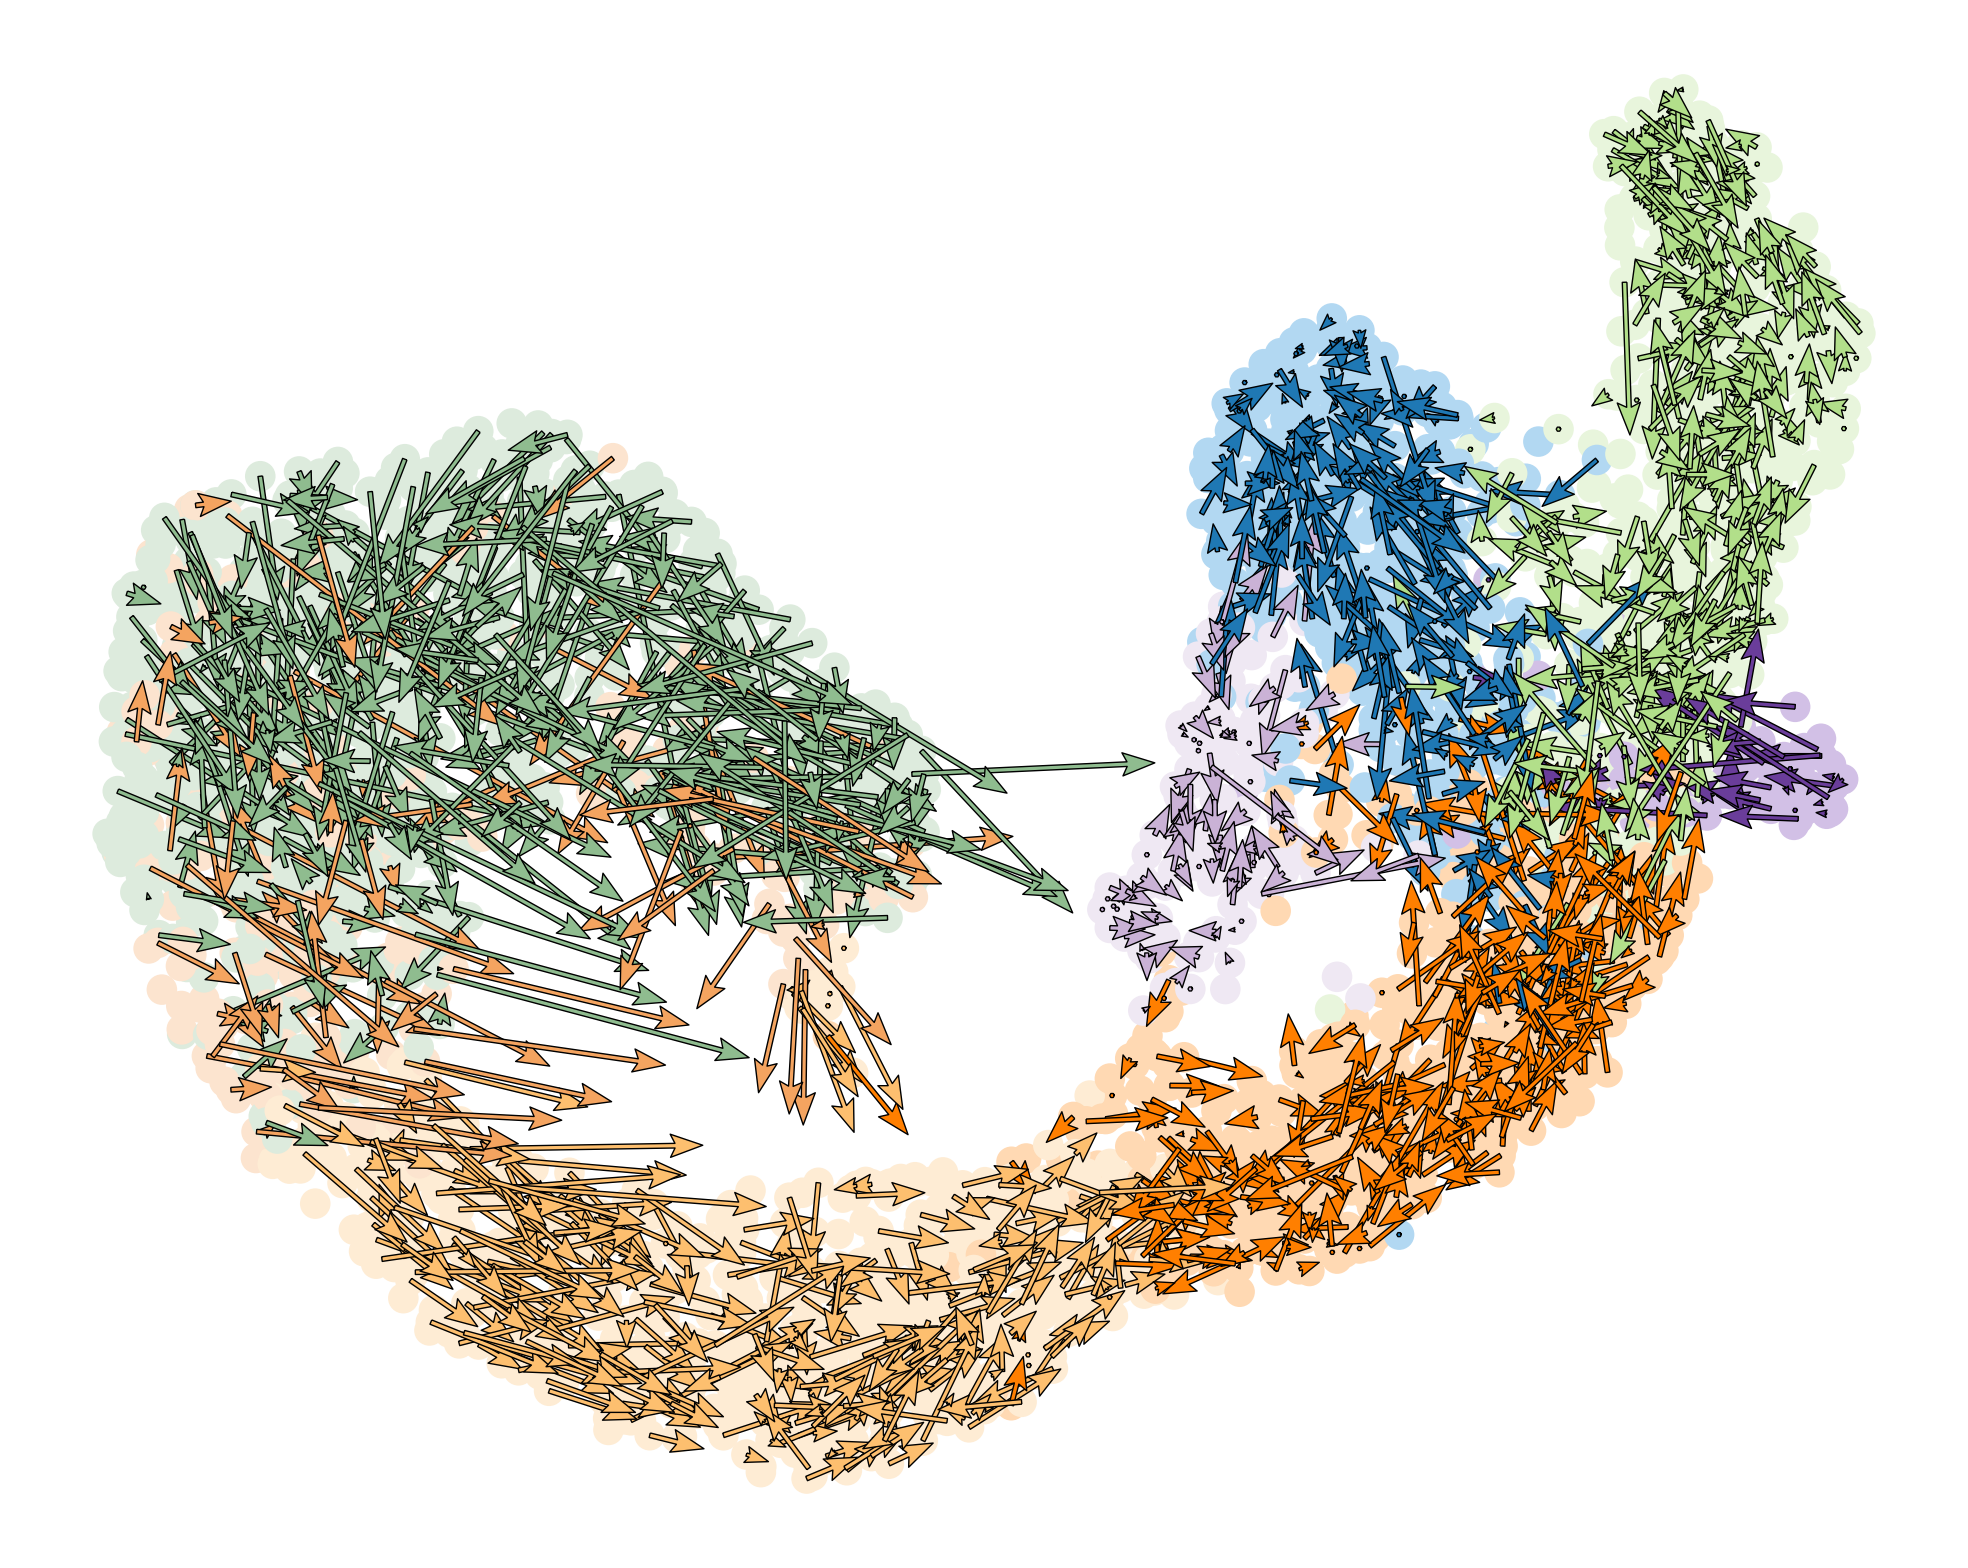

In [24]:
### create UMAP plot (eco-velo visualisation)
fig, ax = plt.subplots(1, 1, **umap_pltkwargs)

ax.scatter(data[:,0], data[:,1], s=100, c=light_color)
ax.axis("off")
ax.quiver(data[sub,0], data[sub,1], v[sub,0], v[sub,1], color=c[sub], **umap_quiver_kwargs)

fig.tight_layout()

# save figure
save_path = "../figures/Fig5C_UMAP_pancreas_eco-velo.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

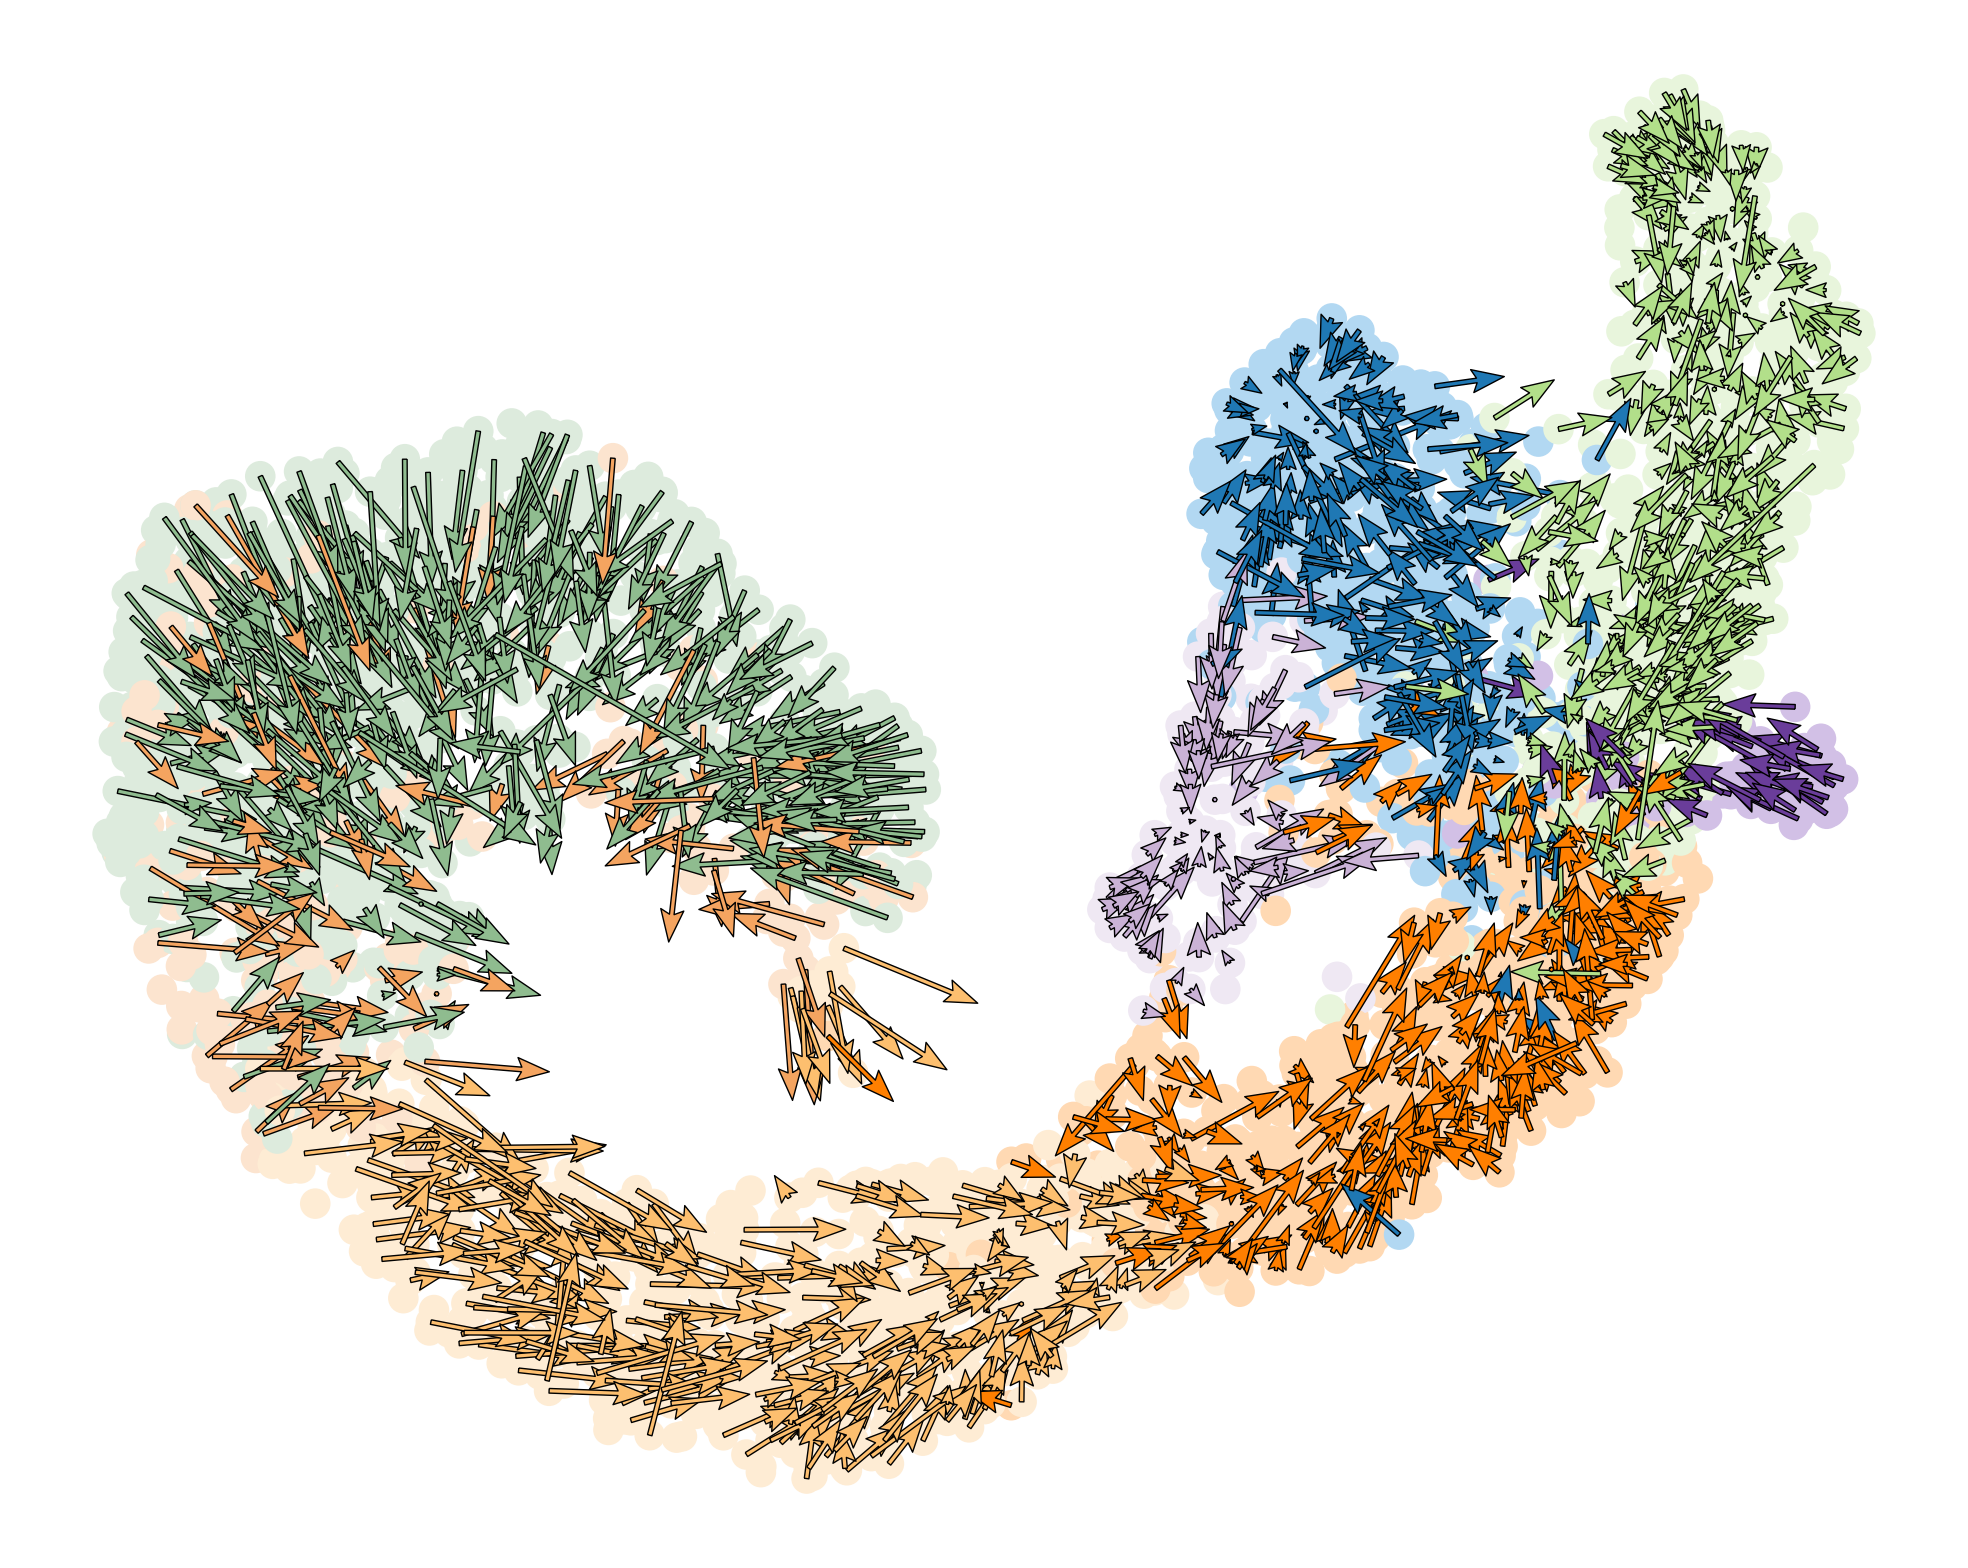

In [25]:
### make smoothed UMAP plot 
fig, ax = plt.subplots(1, 1, **umap_pltkwargs)

ax.scatter(data[:,0], data[:,1], s=100, c=light_color)
ax.axis("off")
ax.quiver(data[sub,0], data[sub,1], v_mean[sub,0], v_mean[sub,1], color=c[sub], **umap_quiver_kwargs)

fig.tight_layout()

# save figure
save_path = "../figures/FigS8_UMAP_pancreas_eco-velo_smoothed.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()